In [2]:
# !pip install PyPortfolioOpt

In [3]:
# 필요한 라이브러리들을 불러옵니다.
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 포트폴리오 최적화를 위한 PyPortfolioOpt 라이브러리
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

# 데이터프레임 출력 옵션 설정
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# --- 설정값 ---
INPUT_FILENAME = "top_50_zscore_rank_3Y.csv"
# ---

try:
    top_50_df = pd.read_csv(INPUT_FILENAME)
    tickers = top_50_df['Ticker'].tolist()
    tickers = list(set(tickers))

    print(f"✅ '{INPUT_FILENAME}'에서 상위 {len(tickers)}개 티커를 불러왔습니다.")
    print(tickers)
except FileNotFoundError:
    print(f"❌ 오류: '{INPUT_FILENAME}' 파일을 찾을 수 없습니다. 이전 단계를 먼저 실행해주세요.")
    tickers = []



✅ 'top_50_zscore_rank_3Y.csv'에서 상위 50개 티커를 불러왔습니다.
['RGTI', 'SMMT', 'IESC', 'HRTG', 'DAVE', 'INOD', 'TGEN', 'PPTA', 'SLNO', 'CRDO', 'APLD', 'ACIC', 'RYTM', 'AAOI', 'STKE', 'AMSC', 'CLS', 'LMB', 'WULF', 'ZEPP', 'MOD', 'CVNA', 'SKYX', 'CIFR', 'VRT', 'ASM', 'TPC', 'OKLO', 'STRL', 'UAMY', 'IONQ', 'HOOD', 'ABBV', 'IREN', 'IAG', 'TMQ', 'MSTR', 'HIMS', 'HCA', 'ASTS', 'FTAI', 'RKLB', 'APP', 'QURE', 'MFH', 'DRUG', 'PSIX', 'POWL', 'TSSI', 'PLTR']


In [4]:
# if tickers:
#     # 데이터 수집 기간 설정 (오늘부터 3년 전까지)
#     end_date = datetime.today()
#     start_date = end_date - timedelta(days=3*365)
    
#     print(f"\n✅ 데이터 수집 기간: {start_date.strftime('%Y-%m-%d')} ~ {end_date.strftime('%Y-%m-%d')}")
    
#     # yfinance를 통해 50개 종목의 수정 종가 데이터를 다운로드합니다.
#     prices = yf.download(tickers, start=start_date, end=end_date)['Adj Close'].dropna(how="all")
#     print("\n✅ 주가 데이터 수집 완료!")
#     display(prices.head())

In [5]:
if tickers:
    # 데이터 수집 기간 설정
    end_date = datetime.today()
    start_date = end_date - timedelta(days=3*365)
    
    print(f"\n✅ 데이터 수집 기간: {start_date.strftime('%Y-%m-%d')} ~ {end_date.strftime('%Y-%m-%d')}")
    
    # yfinance를 통해 전체 데이터를 다운로드합니다.
    # 최신 버전에서는 auto_adjust=True가 기본값이므로 'Adj Close'가 아닌 'Close'를 사용합니다.
    data = yf.download(tickers, start=start_date, end=end_date)
    
    # 'Close' 컬럼만 선택합니다. (이것이 이제 수정 종가입니다)
    if isinstance(data.columns, pd.MultiIndex):
        prices = data['Close'] # 이 부분을 수정
    else:
        prices = data[['Close']] # 이 부분도 수정

    prices = prices.dropna(how="all")
    
    print("\n✅ 주가 데이터 수집 완료!")
    display(prices.head())




✅ 데이터 수집 기간: 2022-10-19 ~ 2025-10-18


/tmp/ipykernel_4178637/3381222765.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  50 of 50 completed



✅ 주가 데이터 수집 완료!


Ticker,AAOI,ABBV,ACIC,AMSC,APLD,APP,ASM,ASTS,CIFR,CLS,CRDO,CVNA,DAVE,DRUG,FTAI,HCA,HIMS,HOOD,HRTG,IAG,IESC,INOD,IONQ,IREN,LMB,MFH,MOD,MSTR,OKLO,PLTR,POWL,PPTA,PSIX,QURE,RGTI,RKLB,RYTM,SKYX,SLNO,SMMT,STKE,STRL,TGEN,TMQ,TPC,TSSI,UAMY,VRT,WULF,ZEPP
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-10-19,2.80,128.236862,0.481426,4.08,2.10,17.440001,0.57,6.84,0.881,9.19,11.01,14.99,10.368,5.400,13.893128,203.986160,4.09,10.11,1.44,1.26,30.549999,3.50,5.01,3.29,7.96,0.776667,14.760000,22.608000,9.78,7.91,20.939550,1.710,1.95,18.570000,1.87,4.19,22.459999,3.60,1.41,1.21,0.320,24.690001,1.125,0.59,6.14,0.61,0.34,11.359422,1.13,5.00
2022-10-20,2.83,128.057648,0.462169,4.00,2.05,17.799999,0.59,6.63,0.888,9.14,11.38,14.48,10.400,5.000,13.633790,203.420578,4.28,9.83,1.32,1.26,30.180000,3.71,5.07,3.09,7.93,0.922222,14.600000,22.101000,9.78,8.04,20.997370,1.700,1.95,18.620001,1.98,4.21,22.410000,3.42,1.44,1.20,0.320,24.160000,1.050,0.59,6.06,0.60,0.35,12.325971,1.11,4.80
2022-10-21,2.74,131.757889,0.414027,4.07,2.01,17.520000,0.63,6.36,0.804,9.25,11.61,14.25,10.240,4.965,14.032061,191.767853,4.37,10.14,1.43,1.38,31.830000,3.63,5.13,3.02,7.95,0.985556,15.280000,23.261999,9.80,8.29,21.469547,1.730,1.80,19.260000,2.05,4.24,23.969999,3.63,1.41,1.12,0.320,24.920000,1.090,0.59,6.28,0.61,0.35,13.162980,1.21,4.68
2022-10-24,2.71,135.189392,0.404398,4.20,2.07,17.670000,0.64,5.98,0.813,9.50,11.71,13.38,9.920,4.900,14.773025,205.127075,4.17,10.21,1.39,1.35,32.369999,3.38,5.06,2.91,7.90,0.988889,15.510000,23.760000,9.83,8.27,21.999538,1.735,1.75,18.469999,2.09,4.25,23.299999,3.64,1.32,1.02,0.368,25.250000,1.030,0.60,6.69,0.61,0.35,13.730951,1.27,4.48
2022-10-25,2.86,134.230713,0.414027,4.32,2.21,18.799999,0.63,6.31,0.828,11.06,12.94,15.28,10.560,5.050,15.152772,209.066544,4.33,10.83,1.39,1.42,32.509998,3.42,5.40,3.39,8.04,0.933333,16.040001,26.868999,9.80,8.66,22.837893,1.770,1.82,18.920000,2.27,4.63,24.320000,3.67,1.30,1.13,0.368,26.340000,1.190,0.57,6.78,0.62,0.36,14.079705,1.41,4.52


In [6]:
if not prices.empty:
    # 1. 연간 기대수익률 계산 (과거 데이터 기반)
    mu = expected_returns.mean_historical_return(prices)
    # mu = expected_returns.ema_historical_return(prices)
    
    # 2. 연간 공분산 행렬 계산 (위험 모델)
    S = risk_models.sample_cov(prices)
    
    print("✅ 연간 기대수익률 (mu):")
    display(mu.head())
    print("\n✅ 연간 공분산 행렬 (S):")
    display(S.head())

✅ 연간 기대수익률 (mu):


Ticker
AAOI    1.262805
ABBV    0.215800
ACIC    1.924672
AMSC    1.464922
APLD    1.551498
dtype: float64


✅ 연간 공분산 행렬 (S):


Ticker,AAOI,ABBV,ACIC,AMSC,APLD,APP,ASM,ASTS,CIFR,CLS,CRDO,CVNA,DAVE,DRUG,FTAI,HCA,HIMS,HOOD,HRTG,IAG,IESC,INOD,IONQ,IREN,LMB,MFH,MOD,MSTR,OKLO,PLTR,POWL,PPTA,PSIX,QURE,RGTI,RKLB,RYTM,SKYX,SLNO,SMMT,STKE,STRL,TGEN,TMQ,TPC,TSSI,UAMY,VRT,WULF,ZEPP
Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAOI,1.536413,0.002300,0.055010,0.383875,0.350658,0.307308,0.102264,0.294305,0.440721,0.262357,0.332472,0.346714,0.254065,-0.241656,0.159233,0.019262,0.228714,0.264092,0.066748,0.094258,0.241779,0.443372,0.389076,0.393271,0.172367,0.060294,0.238372,0.273044,0.195721,0.259964,0.165506,0.065948,0.180611,0.110501,0.430332,0.226087,0.126621,0.180467,0.104927,0.093426,0.307285,0.172745,0.165224,0.066084,0.127127,0.246542,0.146946,0.282281,0.408909,0.188989
ABBV,0.002300,0.052737,0.001628,0.002638,-0.011319,0.006352,0.016156,0.005014,0.006609,0.000830,-0.002590,-0.011416,0.007273,-0.036288,0.009009,0.010917,0.005199,0.007021,0.009832,0.007774,0.002091,-0.005673,0.002373,-0.016609,0.000873,-0.027992,-0.001704,-0.013214,0.000129,0.008088,-0.000408,0.003370,-0.000195,0.007160,0.003363,0.003096,0.019691,0.006769,0.004880,0.026960,-0.015904,-0.003188,0.001971,0.007208,-0.001116,0.018512,0.009734,-0.001782,0.003808,0.010350
ACIC,0.055010,0.001628,1.117680,0.097609,0.188843,0.034111,-0.002901,0.046305,0.115887,0.026771,-0.012970,0.060293,0.069063,-0.000841,0.025508,0.019880,0.012307,0.039868,0.185286,0.041042,0.057753,0.092644,0.089081,0.060854,0.052933,0.032917,0.012693,0.048049,-0.032025,0.053684,0.053376,0.053314,0.075713,0.052673,0.059162,0.049694,0.064125,0.093772,-0.088191,0.001641,-0.046114,0.039596,0.042111,0.041619,0.016159,0.061651,0.019103,0.006317,-0.011473,0.006607
AMSC,0.383875,0.002638,0.097609,0.863438,0.304959,0.181031,0.073089,0.239594,0.278096,0.151465,0.198879,0.321123,0.189018,-0.078830,0.114976,0.021695,0.187246,0.183940,0.092902,0.079688,0.182075,0.333278,0.281671,0.293379,0.160290,0.100617,0.177706,0.240211,0.169483,0.184773,0.104463,0.102681,0.097638,0.094239,0.356203,0.222166,0.177989,0.174654,0.024891,0.192475,0.104066,0.156735,0.138549,0.056385,0.166780,0.192477,0.106465,0.154964,0.280123,0.090647
APLD,0.350658,-0.011319,0.188843,0.304959,1.680751,0.199913,0.128715,0.259938,0.559202,0.158773,0.202856,0.311706,0.173472,-0.050981,0.094534,0.005881,0.179670,0.245091,0.058399,0.102808,0.143431,0.289746,0.380022,0.486300,0.161593,0.149556,0.191003,0.313427,0.244311,0.215601,0.157470,0.188971,0.122420,-0.010464,0.387611,0.231111,0.101596,0.119516,0.115882,0.037063,-0.010193,0.151817,0.221538,0.176796,0.147123,0.318772,0.187220,0.192854,0.608045,0.110669


/data/anaconda3/envs/st_py311/lib/python3.11/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


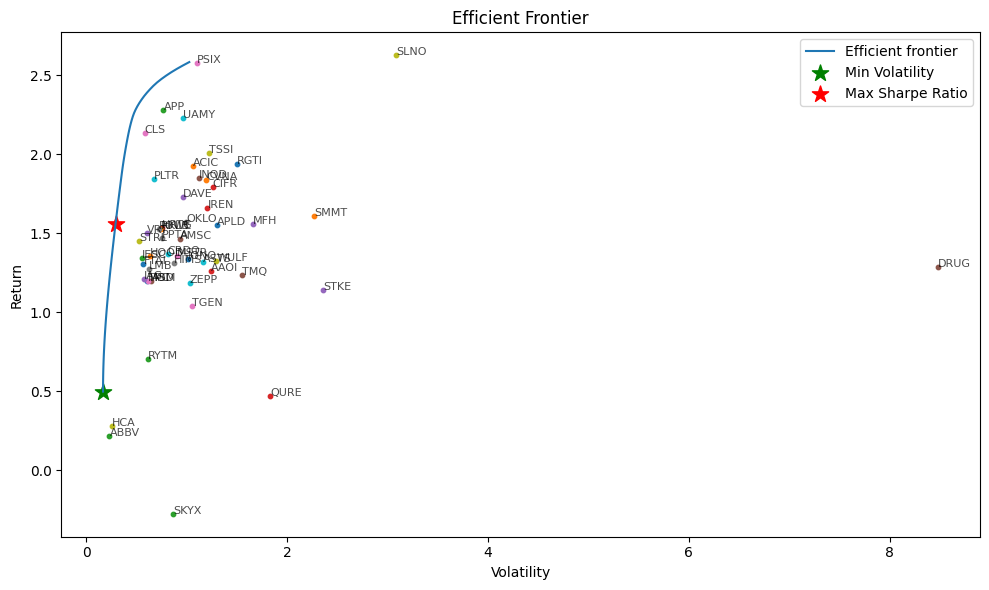


--- 최소 변동성 포트폴리오 ---
기대수익률: 49.63%, 변동성(리스크): 16.55%

--- 최대 샤프 지수 포트폴리오 ---
기대수익률: 156.00%, 변동성(리스크): 29.06%


In [7]:

# 'mu'와 'S'는 이미 계산되었다고 가정합니다.
if 'mu' in locals() and 'S' in locals():
    
    # 1. 최소 변동성 포트폴리오 계산
    # 객체를 새로 생성합니다.
    ef_min_vol = EfficientFrontier(mu, S)
    min_vol_weights = ef_min_vol.min_volatility()
    min_vol_ret, min_vol_risk, _ = ef_min_vol.portfolio_performance()
    
    # 2. 최대 샤프 지수 포트폴리오 계산
    # 객체를 다시 새로 생성합니다.
    ef_max_sharpe = EfficientFrontier(mu, S)
    max_sharpe_weights = ef_max_sharpe.max_sharpe()
    max_sharpe_ret, max_sharpe_risk, _ = ef_max_sharpe.portfolio_performance()

    # 3. 시각화 (효율적 투자선은 한 번만 계산)
    ef_for_plotting = EfficientFrontier(mu, S)
    fig, ax = plt.subplots(figsize=(10, 6))
    plotting.plot_efficient_frontier(ef_for_plotting, ax=ax, show_assets=False)
    
    # 계산된 포트폴리오 결과 플로팅
    ax.scatter(min_vol_risk, min_vol_ret, marker="*", color="g", s=150, label="Min Volatility")
    ax.scatter(max_sharpe_risk, max_sharpe_ret, marker="*", color="r", s=150, label="Max Sharpe Ratio")

    # # 각 포트폴리오의 티커별 위치 표시
    for ticker in tickers:
        ret = mu[ticker]
        risk = np.sqrt(S.loc[ticker, ticker])
        ax.scatter(risk, ret, marker="o", s=10)
        ax.text(risk, ret, ticker, fontsize=8, alpha=0.7)
    

    # 그래프 스타일 설정
    ax.set_title("Efficient Frontier")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    print("\n--- 최소 변동성 포트폴리오 ---")
    print(f"기대수익률: {min_vol_ret:.2%}, 변동성(리스크): {min_vol_risk:.2%}")
    
    print("\n--- 최대 샤프 지수 포트폴리오 ---")
    print(f"기대수익률: {max_sharpe_ret:.2%}, 변동성(리스크): {max_sharpe_risk:.2%}")

In [8]:
def print_weights(weights):
    """가중치를 깔끔하게 출력하는 함수"""
    weights_series = pd.Series(weights)
    # 가중치가 0.1% 이상인 종목만 출력
    print(weights_series[weights_series > 0.001].sort_values(ascending=False).to_string())

if 'ef' in locals():
    # 리스크 범위를 정의합니다 (최소 변동성 ~ 최대 샤프 지수)
    min_risk_level = min_vol_risk
    max_risk_level = max_sharpe_risk
    risk_range = max_risk_level - min_risk_level
    
    # 목표 리스크 수준을 퍼센트로 정의
    target_risk_percentages = [0.60, 0.65, 0.70, 0.80, 0.90, 1.00]
    
    print("\n" + "="*50)
    print("           특정 리스크 수준별 포트폴리오 가중치")
    print("="*50 + "\n")
    
    for p in target_risk_percentages:
        # 목표 변동성(리스크) 값을 계산
        target_risk = min_risk_level + risk_range * p
        
        print(f"--- 리스크 수준: {p:.0%} (목표 변동성: {target_risk:.2%}) ---")
        
        try:
            # 해당 목표 리스크를 달성하는 포트폴리오를 계산
            ef_target_risk = EfficientFrontier(mu, S)

            target_weights = ef_target_risk.efficient_risk(target_volatility=target_risk)
            
            # 가중치 출력
            print_weights(target_weights)
            print("\n" + "-"*50 + "\n")
            
        except Exception as e:
            print(f"해당 리스크 수준의 포트폴리오를 계산할 수 없습니다: {e}\n")

In [9]:
import json # JSON 라이브러리 추가

def print_weights(weights):
    """가중치를 깔끔하게 출력하는 함수"""
    weights_series = pd.Series(weights)
    # 가중치가 0.1% 이상인 종목만 출력
    print(weights_series[weights_series > 0.001].sort_values(ascending=False).to_string())

if 'ef' in locals():
    # 리스크 범위를 정의합니다 (최소 변동성 ~ 최대 샤프 지수)
    min_risk_level = min_vol_risk
    max_risk_level = max_sharpe_risk
    risk_range = max_risk_level - min_risk_level
    
    # 목표 리스크 수준을 퍼센트로 정의
    target_risk_percentages = [0.60, 0.65, 0.70, 0.80, 0.90, 1.00]
    
    print("\n" + "="*50)
    print("           특정 리스크 수준별 포트폴리오 가중치")
    print("="*50 + "\n")
    
    for p in target_risk_percentages:
        # 목표 변동성(리스크) 값을 계산
        target_risk = min_risk_level + risk_range * p
        
        print(f"--- 리스크 수준: {p:.0%} (목표 변동성: {target_risk:.2%}) ---")
        
        try:
            # 해당 목표 리스크를 달성하는 포트폴리오를 계산
            ef_target_risk = EfficientFrontier(mu, S)

            target_weights = ef_target_risk.efficient_risk(target_volatility=target_risk)
            
            # 가중치 출력
            print_weights(target_weights)

            # 📌 추가된 부분: p가 0.65일 때 JSON 파일로 저장
            if p == 0.65:
                # 가중치가 0.1% 이상인 종목만 필터링하여 새로운 딕셔너리 생성
                weights_to_save = {ticker: weight for ticker, weight in target_weights.items() if weight > 0.001}
                
                output_json_filename = 'portfolio_weights_65_risk.json'
                with open(output_json_filename, 'w', encoding='utf-8') as f:
                    json.dump(weights_to_save, f, ensure_ascii=False, indent=4)
                
                print(f"\n  ✨ 65% 리스크 포트폴리오가 '{output_json_filename}' 파일로 저장되었습니다.")

            print("\n" + "-"*50 + "\n")
            
        except Exception as e:
            print(f"해당 리스크 수준의 포트폴리오를 계산할 수 없습니다: {e}\n")

In [16]:

# 맥스 샤프 비율 포트폴리오 가중치를 JSON 파일로 저장
if 'max_sharpe_weights' in locals():
    # 가중치가 0.1% 이상인 종목만 필터링
    filtered_weights = {ticker: weight for ticker, weight in max_sharpe_weights.items() if weight > 0.001}
    
    # JSON 파일로 저장
    output_json_filename = 'portfolio_weights_max_sharpe.json'
    with open(output_json_filename, 'w', encoding='utf-8') as f:
        json.dump(filtered_weights, f, ensure_ascii=False, indent=4)
    
    print(f"\n✅ 맥스 샤프 비율 포트폴리오 가중치가 '{output_json_filename}' 파일로 저장되었습니다.")
    print(f"   - 종목 수: {len(filtered_weights)}")
    print(f"   - 가중치 합계: {sum(filtered_weights.values()):.4f}")


✅ 맥스 샤프 비율 포트폴리오 가중치가 'portfolio_weights_max_sharpe.json' 파일로 저장되었습니다.
   - 종목 수: 22
   - 가중치 합계: 0.9985


In [15]:
input_filename = 'portfolio_weights_max_sharpe.json'
try:
    with open(input_filename, 'r', encoding='utf-8') as f:
        weights = json.load(f)
    
    # 현재 가중치 합계 계산
    current_sum = sum(weights.values())
    
    # 기존 가중치를 조정하여 총합이 0.6이 되도록 스케일링
    M_V = 0.7

    # 모든 가중치를 소수점 자리까지 반올림
    scaling_factor = 1-M_V / current_sum
    scaled_weights = {ticker: weight * scaling_factor for ticker, weight in weights.items()}
    rounded_weights = {ticker: round(weight, 3) for ticker, weight in scaled_weights.items()}

    # MONEY 티커 추가 (비중 0.4)
    scaled_weights['MONEY'] = M_V

    # 라운딩으로 인한 오차를 보정하여 정확히 합계가 1이 되도록 조정
    total_after_rounding = sum(rounded_weights.values())
    if total_after_rounding != 1.00:
        # 가장 큰 가중치를 가진 티커에 오차를 더하거나 빼서 합계를 1로 맞춤
        max_ticker = max(rounded_weights.items(), key=lambda x: x[1] if x[0] != 'MONEY' else 0)[0]
        rounded_weights[max_ticker] = round(rounded_weights[max_ticker] + (1.00 - total_after_rounding), 3)
    
    # 최종 포트폴리오 가중치를 JSON 파일로 저장
    output_filename = 'final_portfolio_weights.json'
    with open(output_filename, 'w', encoding='utf-8') as f:
        json.dump(rounded_weights, f, ensure_ascii=False, indent=4)
    
    print(f"\n✅ 최종 포트폴리오 가중치가 '{output_filename}' 파일로 저장되었습니다.")
    print(f"   - MONEY 비중: {rounded_weights.get('MONEY', 0):.3f}")
    print(f"   - 기타 자산 비중 총합: {sum(rounded_weights.values()) - rounded_weights.get('MONEY', 0):.3f}")
    print(f"   - 전체 비중 총합: {sum(rounded_weights.values()):.3f}")
    
except FileNotFoundError:
    print(f"❌ 오류: '{input_filename}' 파일을 찾을 수 없습니다. 이전 단계를 먼저 실행해주세요.")
except Exception as e:
    print(f"❌ 오류 발생: {str(e)}")


✅ 최종 포트폴리오 가중치가 'final_portfolio_weights.json' 파일로 저장되었습니다.
   - MONEY 비중: 0.000
   - 기타 자산 비중 총합: 1.000
   - 전체 비중 총합: 1.000


In [20]:
import json

# --- 설정 ---
# 1. 최대 샤프 지수 가중치가 저장된 JSON 파일 경로
max_sharpe_weights_path = r'final_portfolio_weights.json'
# 2. 최종 포트폴리오를 저장할 파일 경로 (선택 사항)
final_portfolio_path = r'final_portfolio_with_cash.json'

# 3. 고정할 현금(MONEY) 비중
CASH_WEIGHT = 0.8
# 4. 나머지 자산에 할당될 비중
EQUITY_WEIGHT = 1 - CASH_WEIGHT

# --- 로직 ---
# 기존 포트폴리오 가중치 로드
with open(max_sharpe_weights_path, 'r', encoding='utf-8') as f:
    original_weights = json.load(f)

# 새로운 가중치를 계산할 딕셔너리 생성
adjusted_weights = {}

# 각 자산의 가중치를 남은 비중(0.6)에 맞춰 재계산하고 소수점 3자리에서 반올림
for ticker, weight in original_weights.items():
    adjusted_weights[ticker] = round(weight * EQUITY_WEIGHT, 3)

# 소수점 3자리에서 0.000인 항목 제거
adjusted_weights = {k: v for k, v in adjusted_weights.items() if v != 0.000}

# 반올림 후 MONEY를 제외한 나머지의 합계 계산
equity_sum = sum(adjusted_weights.values())

# MONEY를 제외한 나머지의 합이 정확히 0.6이 되도록 조정
if equity_sum != EQUITY_WEIGHT:
    # 가장 큰 가중치를 가진 자산에 오차를 보정
    difference = round(EQUITY_WEIGHT - equity_sum, 3)
    max_ticker = max(adjusted_weights.items(), key=lambda x: x[1])[0]
    adjusted_weights[max_ticker] = round(adjusted_weights[max_ticker] + difference, 3)

# 현금 비중 추가
adjusted_weights['MONEY'] = CASH_WEIGHT

# --- 결과 확인 ---
print(f"✅ 현금 비중 {CASH_WEIGHT}를 적용하여 포트폴리오 가중치를 재조정했습니다.")
print("\n--- 최종 조정된 포트폴리오 가중치 ---")

# 보기 좋게 정렬하여 출력
for ticker, weight in sorted(adjusted_weights.items()):
    print(f"- {ticker:<6}: {weight:.3f}")

print("---------------------------------------")
# MONEY를 제외한 자산들의 합계와 전체 합계 검증
equity_total = sum(v for k, v in adjusted_weights.items() if k != 'MONEY')
total_weight = sum(adjusted_weights.values())
print(f"📊 MONEY 제외 총 가중치: {equity_total:.3f}")
print(f"📊 전체 가중치 합계: {total_weight:.3f}")


# --- 파일 저장 (필요시 주석 해제) ---
with open(final_portfolio_path, 'w', encoding='utf-8') as f:
    json.dump(adjusted_weights, f, indent=4)
print(f"\n✅ 조정된 포트폴리오를 '{final_portfolio_path}' 파일에 저장했습니다.")


✅ 현금 비중 0.8를 적용하여 포트폴리오 가중치를 재조정했습니다.

--- 최종 조정된 포트폴리오 가중치 ---
- ABBV  : 0.009
- ACIC  : 0.004
- APP   : 0.005
- ASM   : 0.001
- CLS   : 0.150
- FTAI  : 0.003
- HCA   : 0.002
- HRTG  : 0.004
- IAG   : 0.004
- MFH   : 0.002
- MONEY : 0.800
- PLTR  : 0.002
- POWL  : 0.002
- PPTA  : 0.001
- PSIX  : 0.004
- SLNO  : 0.001
- STRL  : 0.001
- TSSI  : 0.001
- UAMY  : 0.003
- ZEPP  : 0.001
---------------------------------------
📊 MONEY 제외 총 가중치: 0.200
📊 전체 가중치 합계: 1.000

✅ 조정된 포트폴리오를 'final_portfolio_with_cash.json' 파일에 저장했습니다.
